## Input the required libraries

In [1]:
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model

## Input the Dataset

In [4]:
# function that would read an image provided the image path, preprocess and return it back

def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (256, 256)) # resizing it (I just like it to be powers of 2)
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [5]:
X_train = [] # To store train images
y_train = [] # To store train labels

# labels -
# 0 - Covid
# 1 - Viral Pneumonia
# 2 - Normal

train_path = './dataset/train/' # path containing training image samples

In [6]:
for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X_train.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_train.append(0) # Covid
        elif folder.name[0]=='V':
            y_train.append(1) # Viral Pneumonia
        else:
            y_train.append(2) # Normal

In [7]:
X_train = np.array(X_train)
X_train.shape # We have 1955 training samples in total

(1955, 256, 256, 3)

In [8]:
y_train = np.array(y_train)
y_train.shape

(1955,)

In [9]:
X_aug = []
y_aug = []

for i in range(0, len(y_train)):
    X_new = np.fliplr(X_train[i])
    X_aug.append(X_new)
    y_aug.append(y_train[i])

In [10]:
X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

In [11]:
X_train = np.append(X_train, X_aug, axis=0) # appending augmented images to original training samples
X_train.shape

(3910, 256, 256, 3)

In [12]:
y_train = np.append(y_train, y_aug, axis=0)
y_train.shape
# Now we have 3910 samples in total

(3910,)

## Splitting the Data

In [13]:
# We have splitted our data in a way that - 
# 1. The samples are shuffled
# 2. The ratio of each class is maintained (stratify)
# 3. We get same samples every time we split our data (random state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True, stratify=y_train, random_state=123)

In [14]:
# we will use 3323 images for training the model
y_train.shape

(3323,)

In [15]:
# we will use 587 images for validating the model's performance
y_val.shape

(587,)

In [16]:
del X_aug
del y_aug

## Converting the pretrained model to TFLite Model

In [17]:
# Load pretrained model (best saved one)
with open('./Saved Model/covid_classifier_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('./Saved Model/covid_classifier_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics= ["accuracy"])

In [18]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 256, 256, 3)       3         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 255, 255, 32)      483       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 63, 63, 32)        1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 63, 63, 64)        18627     
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 21, 21, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 21, 21, 64)        1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 21, 21, 64)        6

In [21]:
history = q_aware_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 5)

Epoch 1/5
104/104 [==============================] - 120s 1s/step - loss: 0.0360 - accuracy: 0.9874 - val_loss: 0.1099 - val_accuracy: 0.9659
Epoch 2/5
104/104 [==============================] - 122s 1s/step - loss: 0.0425 - accuracy: 0.9874 - val_loss: 0.1003 - val_accuracy: 0.9693
Epoch 3/5
104/104 [==============================] - 121s 1s/step - loss: 0.0350 - accuracy: 0.9886 - val_loss: 0.0887 - val_accuracy: 0.9642
Epoch 4/5
104/104 [==============================] - 117s 1s/step - loss: 0.0342 - accuracy: 0.9883 - val_loss: 0.1055 - val_accuracy: 0.9642
Epoch 5/5
104/104 [==============================] - 116s 1s/step - loss: 0.0337 - accuracy: 0.9871 - val_loss: 0.0874 - val_accuracy: 0.9710


## Loading the Test Images

In [23]:
X_test = [] # To store test images
y_test = [] # To store test labels

test_path = './dataset/test/'

for folder in os.scandir(test_path):
    for entry in os.scandir(test_path + folder.name):

        X_test.append(read_and_preprocess(test_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_test.append(0)
        elif folder.name[0]=='V':
            y_test.append(1)
        else:
            y_test.append(2)
            
X_test = np.array(X_test)
y_test = np.array(y_test)

In [24]:
X_test.shape # We have 185 images for testing

(185, 256, 256, 3)

In [25]:
# making predictions
predictions = q_aware_model.predict(X_test)

In [26]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [27]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

0.9891891891891892

<AxesSubplot:>

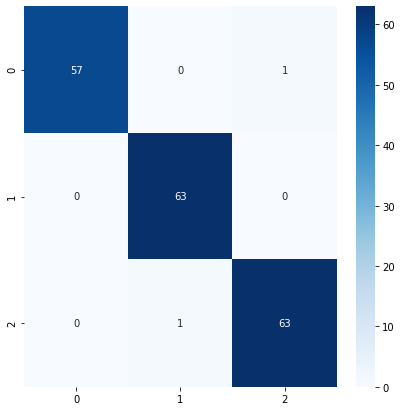

In [28]:
# plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap='Blues')

# The model misclassified one Covid case as Normal and one Normal case as Viral Pneumonia

In [32]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       0.98      1.00      0.99        63
           2       0.98      0.98      0.98        64

    accuracy                           0.99       185
   macro avg       0.99      0.99      0.99       185
weighted avg       0.99      0.99      0.99       185



In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\kanak\AppData\Local\Temp\tmp5lkdlpmq\assets


INFO:tensorflow:Assets written to: C:\Users\kanak\AppData\Local\Temp\tmp5lkdlpmq\assets


In [34]:
print("Model size reduced from 30.1 MB to ", np.around(len(tflite_qaware_model)/(1024*1024),2), " MB")

Model size reduced from 30.1 MB to  2.41  MB


In [35]:
with open("covid_classifier.tflite", 'wb') as f:
    f.write(tflite_qaware_model)